In [7]:
import os 

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome')
    train_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/train.csv'
    test_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/test.csv'
    IN_COLAB = True
except:
    os.chdir(r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\Connectome Projekt\Connectome')
    train_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\train.csv'
    test_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\test.csv'
    IN_COLAB = False

!pip install .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing /content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for src: filename=src-0.1.0-py3-none-any.whl size=29178 sha256=32b2dc3ba7175e8d9edafe34c51720f8280f633c3ba0da7b18d21b66416c4ec7
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3iyffmu/wheels/33/78/f1/218471f49448b8e9df2af6ab9b92633a6fe2826c87471eba83
Successfully built src
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Unins

### Importing Libraries

In [8]:
!pip install interpret
!pip install bctpy

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from interpret import show


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import scipy.stats

import bct
import src.preprocessing.data_loader as dtl
from math import sqrt
from datetime import date


plt.style.use("ggplot")
%matplotlib inline

### Loading and Transforming Data

In [10]:
%%time
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

CPU times: user 29.7 s, sys: 974 ms, total: 30.7 s
Wall time: 52.9 s


In [11]:
y, X = dtl.preprocess_data(train)
X = X.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
y_test, X_test = dtl.preprocess_data(test)
X_test = X_test.drop(columns = ['MEM_score', 'Apoe'], inplace = False)


### Baseline Model

In [12]:
%%time
lgb_baseline = lgb.LGBMClassifier(objective="binary")
lgb_baseline.fit(X, y)

CPU times: user 3min 54s, sys: 2.27 s, total: 3min 56s
Wall time: 2min 19s


In [15]:
ssc = StandardScaler()
X = ssc.fit_transform(X)
X_test = ssc.transform(X_test)

In [33]:
#other possible sovler for l1: liblinear
lrcv = LogisticRegressionCV(cv=5, max_iter=50000, n_jobs=-1, penalty='elasticnet', solver='saga', l1_ratios=list(np.linspace(0., 1., 10))).fit(X, y)

KeyboardInterrupt: ignored

In [31]:
np.where(lrcv.coef_ != 0)[1].shape

(20078,)

In [ ]:
%%time
ebm = ExplainableBoostingClassifier()
ebm.fit(X, y)

In [ ]:
show(ebm.explain_global())

Text(0, 0.5, 'Feature Importance Score')

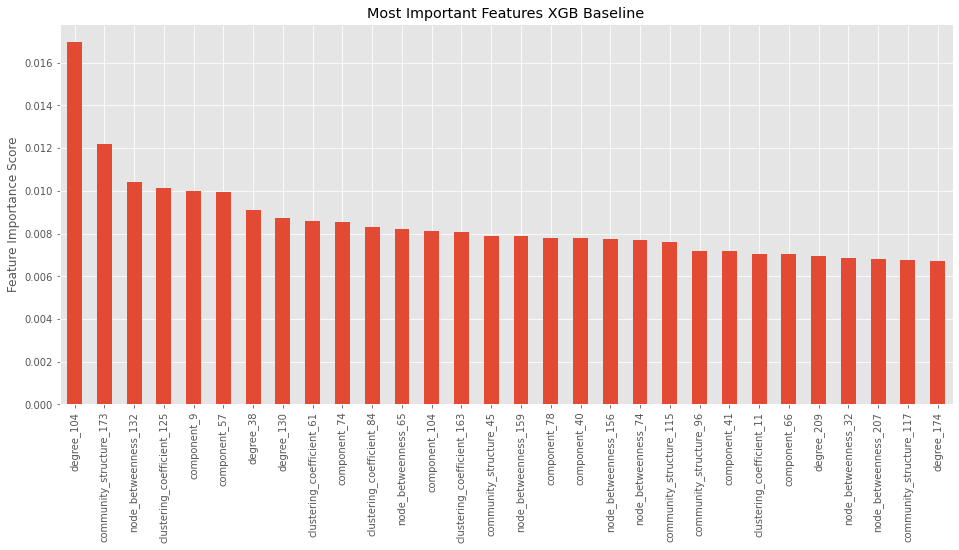

In [ ]:
features = list(graph_train_df.columns)
feat_imp = pd.Series(xgb_baseline.feature_importances_, features).sort_values(ascending=False)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(7)
feat_imp[0:30].plot(kind='bar', title='Most Important Features XGB Baseline')
plt.ylabel('Feature Importance Score')


In [ ]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_baseline.score(graph_test_df, y_test)), "\n")
pred = lgb_baseline.predict(graph_test_df)
print("Classification Report - LGB Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.788 

Classification Report - LGB Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.79      0.70      0.74        37
         1.0       0.79      0.85      0.82        48

    accuracy                           0.79        85
   macro avg       0.79      0.78      0.78        85
weighted avg       0.79      0.79      0.79        85



In [ ]:
print('Accuracy of the EBM on test set: {:.3f}'.format(ebm.score(graph_test_df, y_test)), "\n")
pred = ebm.predict(graph_test_df)
print("Classification Report - EBM Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the EBM on test set: 0.612 

Classification Report - EBM Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.55      0.57      0.56        37
         1.0       0.66      0.65      0.65        48

    accuracy                           0.61        85
   macro avg       0.61      0.61      0.61        85
weighted avg       0.61      0.61      0.61        85

